In [1]:
import os
from matrix_client.api import MatrixHttpApi
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matrixstats import get_all_events, get_rooms_in_community, filter_events_by_messages
from matrixstats import print_sorted_len, print_sorted_value, flatten_dicts

In [2]:
with open(".matrix_token") as f:
    token = str(f.read()).strip()

homeserver = "https://matrix.cadair.com"

api = MatrixHttpApi(homeserver, token=token)

In [3]:
ids = get_rooms_in_community(api, "+astropy:openastronomy.org")
ids['sunpy'] = '!MeRdFpEonLoCwhoHeT:matrix.org'
ids = {'astropy': get_rooms_in_community(api, "+astropy:openastronomy.org"),
       'sunpy': get_rooms_in_community(api, "+sunpy:openastronomy.org")}

In [88]:
# Get all the messages in all the rooms
events = {group: get_all_events(api, cids, cache=f"{group}_messages.h5", refresh_cache=False)
          for group, cids in ids.items()}

# Pop out this chat as it's old and full of freenode spam
_ = events['astropy'].pop("astropy_irc_and_gitter")
# Pop out this one as it has no messages in it
_ = events['astropy'].pop("astropy_workshops")
_ = events['astropy'].pop("astropy_matrix_test")

# Filter by actual messages
messages = {group: filter_events_by_messages(gevents) for group, gevents in events.items()}

for gmessages in messages.values():
    for m in gmessages.values():
        m.loc[:,'usender'] = [a.split(":")[0][1:].split("_")[-1] if "slack" in a else a for a in m['sender']]

/opt/miniconda/envs/matrix/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/miniconda/envs/matrix/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [89]:
all_messages = {group: pd.concat(gmessages).reset_index(level=0) for group, gmessages in messages.items()}

In [90]:
print_sorted_len(flatten_dicts(messages))

sunpy: 49404
irispy: 8307
astropy_general: 3809
drms: 2777
astropy_pkg_infrastructure: 1388
astropy_ci_issues: 1191
astropy_random: 939
sunpy_infrastructure: 838
astropy_astropy_bot: 491
astropy_releasing: 460
astropy_astroquery: 347
astropy_meeting2018_logistics: 315
astropy_coordinates: 271
astropy_fits: 161
astropy_leaveslack: 105
astropy_meeting2018_social: 86
astropy_table: 81
astropy_performance: 80
astropy_affiliated_imexam: 79
astropy_regions: 67
astropy_wcs_ape: 58
astropy_units: 52
astropy_learn: 51
astropy_affiliated_general: 50
astropy_cssi_nsf_grant: 35
astropy_modeling: 34
astropy_wcs: 33
astropy_paper_ii: 27
astropy_spectroscopy: 21
astropy_ihateconda: 20
astropy_jobs: 19
astropy_astroquery_paper: 16
astropy_gsoc: 8
astropy_git: 3
astropy_ginga: 1
astropy_web_pages: 1
astropy_halotools: 0
astropy_usage_stat: 0
astropy_utils: 0


In [91]:
channel_creation = {k:v.index[-1] for k, v in flatten_dicts(events).items()}

print_sorted_value(channel_creation, reverse=False)

sunpy: 2016-09-30 04:58:02.321000
drms: 2017-05-08 08:45:46.094000
irispy: 2017-05-22 09:04:46.728000
astropy_general: 2017-10-09 06:43:25.195000
astropy_pkg_infrastructure: 2018-02-22 04:49:41.385000
sunpy_infrastructure: 2018-04-23 06:33:35.460000
astropy_affiliated_general: 2018-05-15 05:39:07.269000
astropy_astropy_bot: 2018-05-15 05:39:09.553000
astropy_astroquery: 2018-05-15 05:39:40.092000
astropy_astroquery_paper: 2018-05-15 05:39:49.056000
astropy_ci_issues: 2018-05-15 05:40:02.322000
astropy_coordinates: 2018-05-15 05:40:27.315000
astropy_cssi_nsf_grant: 2018-05-15 05:40:52.317000
astropy_fits: 2018-05-15 05:41:17.321000
astropy_git: 2018-05-15 05:42:03.017000
astropy_gsoc: 2018-05-15 05:42:27.316000
astropy_halotools: 2018-05-15 05:42:52.315000
astropy_jobs: 2018-05-15 05:43:42.315000
astropy_learn: 2018-05-15 05:44:07.316000
astropy_leaveslack: 2018-05-15 05:44:37.314000
astropy_paper_ii: 2018-05-15 05:45:30.456000
astropy_performance: 2018-05-15 05:45:52.317000
astropy_ran

In [92]:
messages_per_day = {group: pd.DataFrame({k:m['body'].resample("1D").count() for k,m in gm.items() if not m.empty})
                    for group, gm in messages.items()}

In [93]:
messages_per_week = {group: pd.DataFrame({k:m['body'].resample("1W").count() for k,m in gm.items() if not m.empty})
                     for group, gm in messages.items()}

In [94]:
total_mpd = {group: df.sum(axis=1) for group, df in messages_per_day.items()}
total_mpw = {group: df.sum(axis=1) for group, df in messages_per_week.items()}

## Total Messages per Day

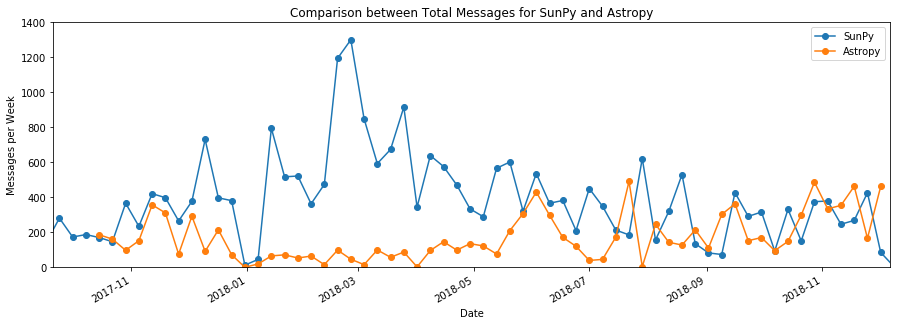

In [95]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Comparison between Total Messages for SunPy and Astropy")

ax.plot(total_mpw['sunpy'].index, total_mpw['sunpy'], "-o", label="SunPy")
ax.plot(total_mpw['astropy'].index, total_mpw['astropy'], "-o", label="Astropy")

fig.autofmt_xdate()
plt.legend()

ax.set_ylabel("Messages per Week")
ax.set_xlabel("Date")
ax.axis((736592.85, 737035.15, 0.0, 1400))
None

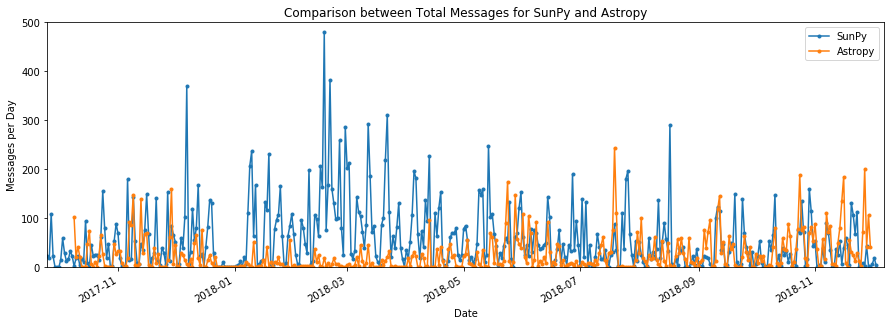

In [96]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Comparison between Total Messages for SunPy and Astropy")

ax.plot(total_mpd['sunpy'].index, total_mpd['sunpy'], "-o", ms=3, label="SunPy")
ax.plot(total_mpd['astropy'].index, total_mpd['astropy'], "-o", ms=3, label="Astropy")

fig.autofmt_xdate()
plt.legend()

ax.set_ylabel("Messages per Day")
ax.set_xlabel("Date")
ax.axis((736596.85, 737035.15, 0.0, 500))
None

## Senders per Day

In [121]:
total_senders = {group: {k: m.groupby("usender").count()['body'] for k,m in gm.items()}
                 for group, gm in messages.items()}

In [137]:
senders = pd.DataFrame(all_messages['astropy'].groupby("usender").count()['body'].sort_values(ascending=False))
senders = senders[:15]

display_names = []
for s in senders.index:
    m = True
    if s == "@Cadair:matrix.org":
        s = "@cadair:cadair.com"
    if ":" not in s:
        s = f"@slack_astropy_{s}:openastronomy.org"
        m = False
    try:
        dn = api.get_display_name(s)
    except Exception:
        dn = s
    if m:
        dn += "*"
    display_names.append(dn)

senders['display_name'] = display_names

senders = senders.reset_index()
senders = senders.set_index("display_name")
_ = senders.pop("usender")
senders = senders.groupby(senders.index).sum().sort_values(by='body', ascending=False)
senders

,body
display_name,
bsipocz,2154
Cadair*,1755
pllim,1449
astrofrog,1286
dan,484
eteq,418
adamginsburg,396
saimn,312
adrn,223


In [138]:
senders_per_day = {group: pd.DataFrame({k: m.resample("1D").agg({'usender': 'nunique'})['usender']
                                        for k, m in gm.items() if not m.empty})
                   for group, gm in messages.items()}

In [139]:
senders_per_day = {group: am.resample("1D").agg({'usender': 'nunique'})['usender'] for group, am in all_messages.items()}

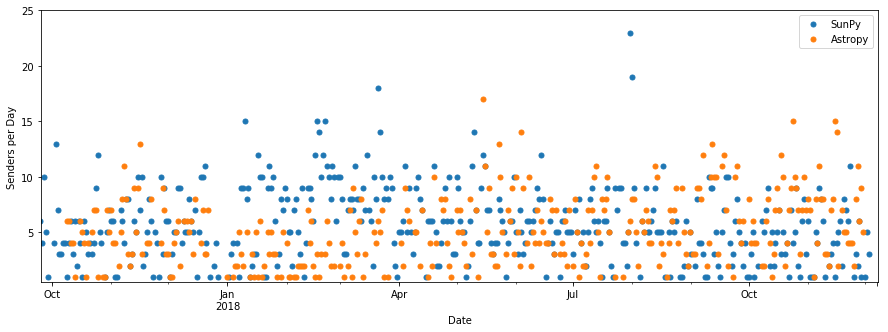

In [164]:
fig, ax = plt.subplots(figsize=(15,5))

senders_per_day['sunpy'].plot(ax=ax, label="SunPy", style=".", ms=10)
senders_per_day['astropy'].plot(ax=ax, label="Astropy", style=".", ms=10)

plt.legend()

ax.set_ylabel("Senders per Day")
ax.set_xlabel("Date")

ax.axis((17434.3, 17872.7, 0.5, 25))
None

## Messages per Day vs Senders per Day

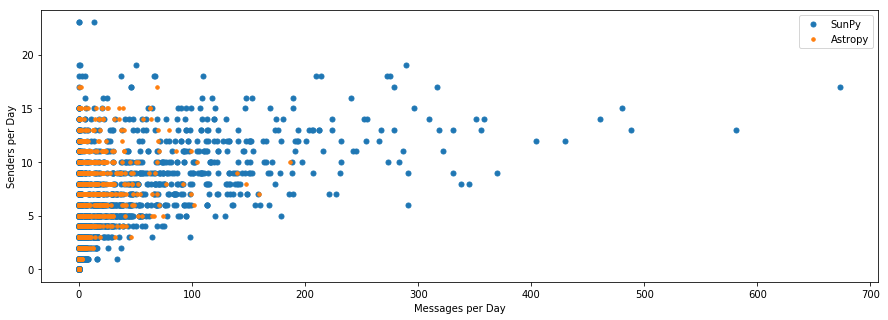

In [141]:
plt.figure(figsize=(15,5))
sp = plt.plot(messages_per_day['sunpy'], senders_per_day['sunpy'], ".", color="C0", ms=10)
ap = plt.plot(messages_per_day['astropy'], senders_per_day['astropy'], ".", color="C1", ms=7)
plt.xlabel("Messages per Day")
plt.ylabel("Senders per Day")
plt.legend((sp[0], ap[0]), ("SunPy", "Astropy"))